In [209]:
import numpy as np

from helpers import plot_metric
from track import degs, corners, pseudo_straights, corner_dir, pseudo_straight_max_length, straights
from waypoints import waypoints

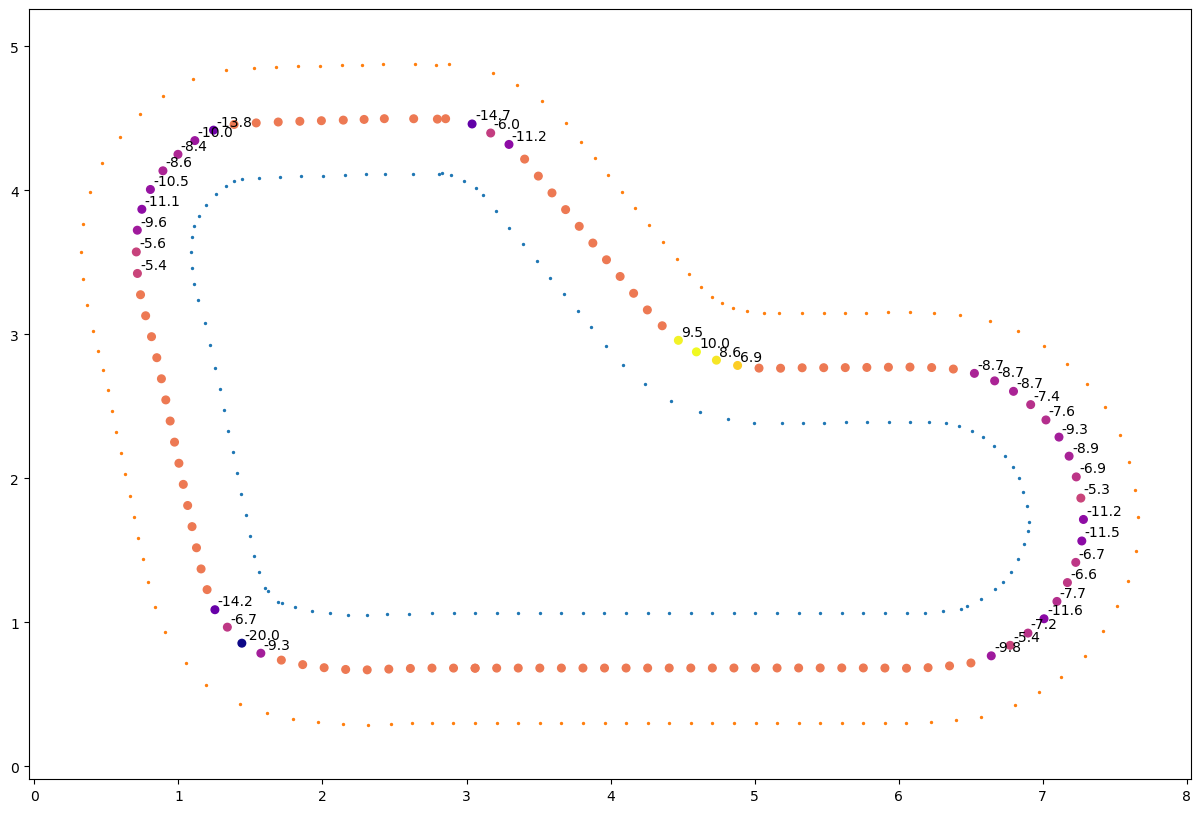

In [210]:
plot_metric(degs)

## Side weights

In [211]:
corner_weights = degs.copy()
for s, e in corners:
    corner = corner_weights[s:e]
    # corner = np.pad(corner, pad_width=5)
    corner = np.convolve(corner, np.ones(corner.shape[0]), mode="same")
    # abs_min = min(np.abs(corner.min()), np.abs(corner.max()))
    abs_min = min(corner.min() - 4, corner.max() + 4, key=abs)
    abs_max_value = max(np.abs(corner.min()) - np.abs(abs_min), np.abs(corner.max()) - np.abs(abs_min))
    new_weights = ((corner - abs_min) / abs_max_value)
    corner_weights[s:e] = new_weights
    # corner_weights[e1:s2] = (corner/abs_max)[min_curve_length-1:-(min_curve_length-1)]

In [212]:
straight_weight = np.zeros(len(waypoints))
p = 3
for (start, end), (r1, r2) in zip(straights,
                                  [*list(zip(corner_dir[:-1], corner_dir[1:])), (corner_dir[-1], corner_dir[0])]):
    if r1 - r2 == 0:
        if start > end:
            end += straight_weight.shape[0]
        x = np.linspace(-1, 1, (end - p) - (start + p))
        f = -x ** 2 - 1
        f = (f - f.min()) / (1 - f.min())
        f = f * min((end - start) / (pseudo_straight_max_length - 50), 1)
        straight_weight.put(range(start + p, end - p), f, mode="wrap")

straight_weight = straight_weight / np.max(straight_weight)

In [213]:
side_weights = corner_weights + straight_weight

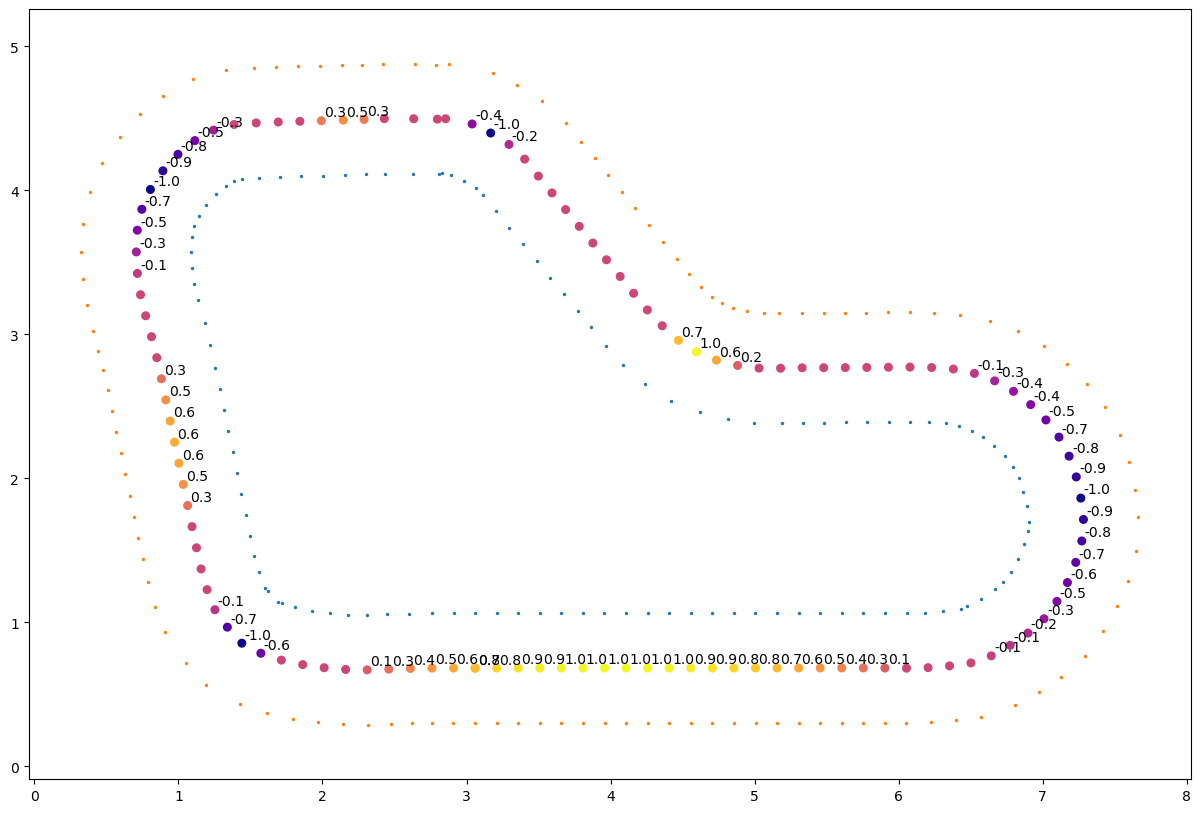

In [214]:
plot_metric(side_weights)

## Speed weights

In [215]:
speed_weights = np.ones(waypoints.shape[0])

In [216]:
for s, e in pseudo_straights:
    if s > e:
        e += speed_weights.shape[0]

    x = np.linspace(-1, 1, e - s)
    f = -(x + 0.1) ** 4 - 1
    f = (f - f.min()) / (1 - f.min())
    f = f * min((e - s) / (pseudo_straight_max_length - 50), 1)
    speed_weights.put(range(s, e), f, mode="wrap")

In [217]:
speed_weights = speed_weights - abs(0.001 * np.convolve(degs, [1, 2, 4, 2, 1], mode="same"))
speed_weights[speed_weights < 0] = 0
speed_weights = speed_weights / np.max(speed_weights)

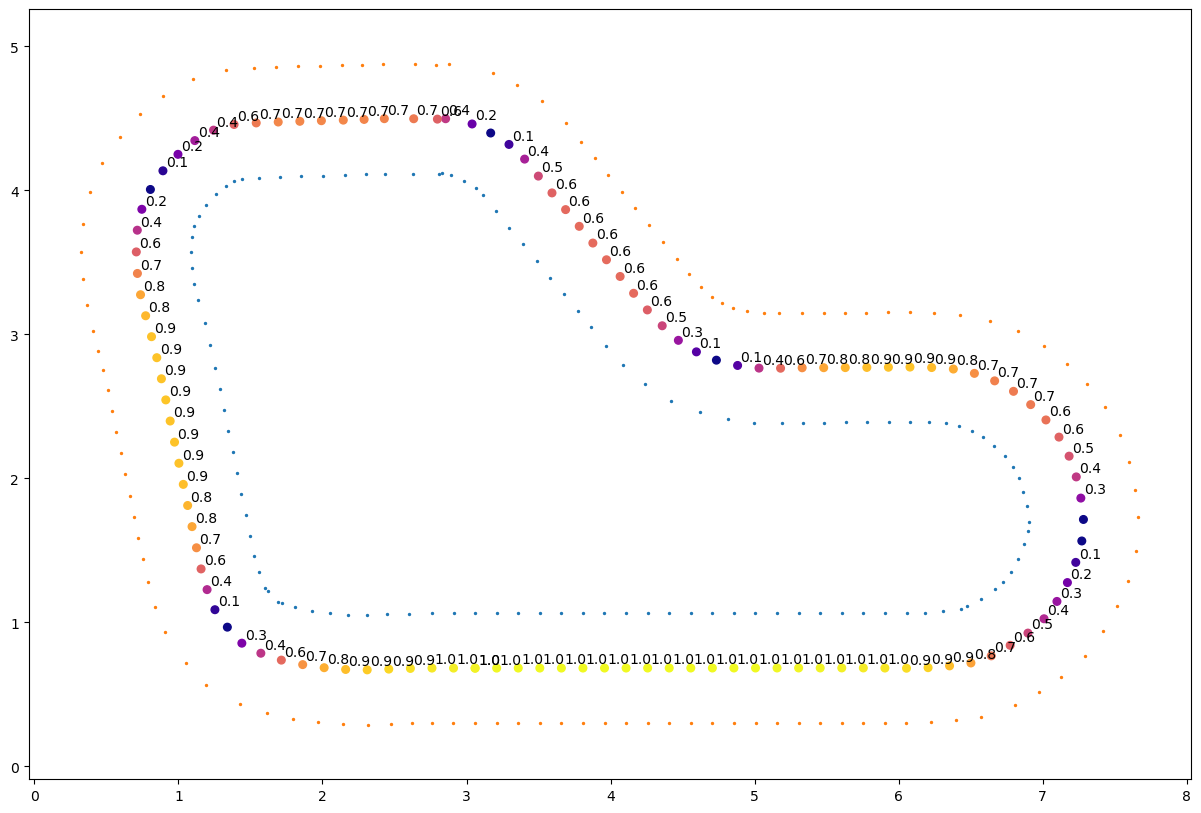

In [218]:
plot_metric(speed_weights)

## Steering weights

In [219]:
steering_weights = np.convolve(corner_weights, np.ones(7), mode="same")
max_elem = max(np.abs(steering_weights.max()), np.abs(steering_weights.min()))
steering_weights = steering_weights / max_elem

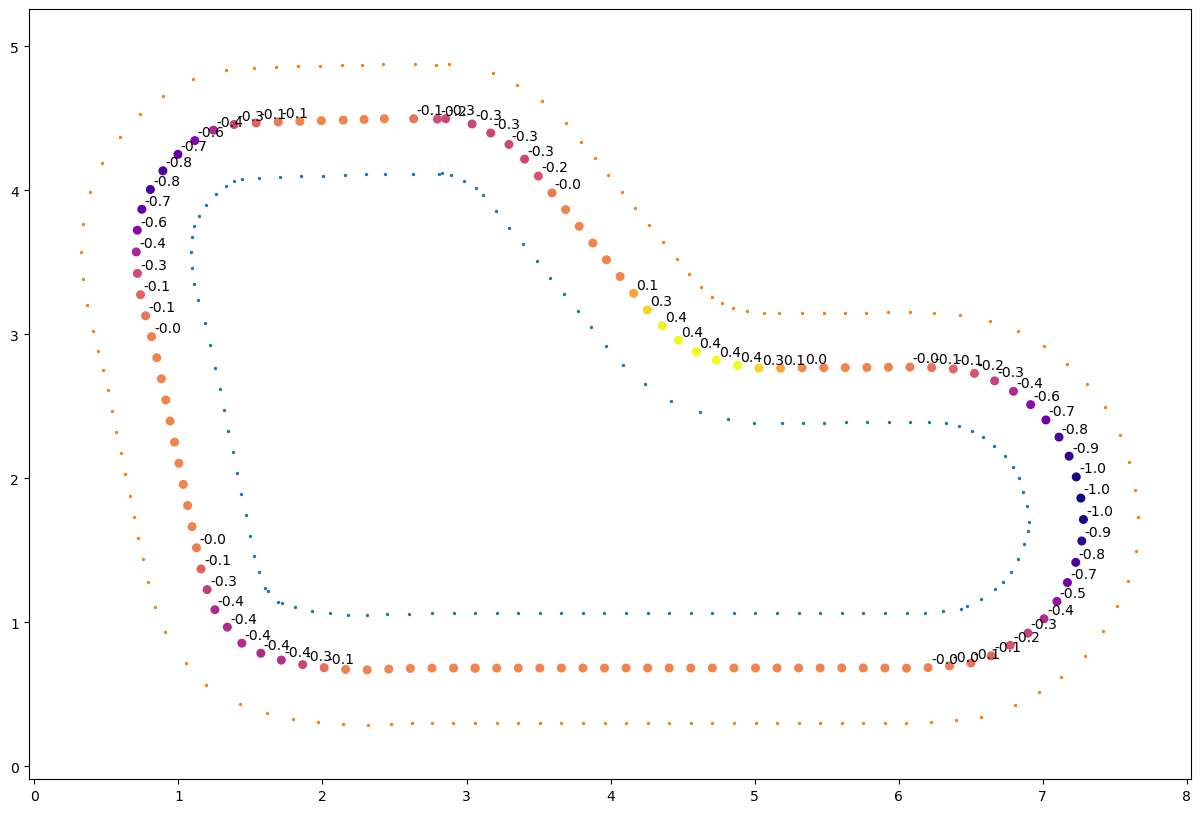

In [220]:
plot_metric(steering_weights)

# No-steering weights

In [221]:
no_steering_weights = steering_weights.copy()
no_steering_weights = np.convolve(no_steering_weights, [1, 2, 4, 6, 4, 2, 1], mode="same")
no_steering_weights = np.ones(len(steering_weights)) - abs(no_steering_weights)
no_steering_weights[no_steering_weights < 0] = 0

In [222]:
no_steering_weights = np.roll(no_steering_weights, shift=-1)

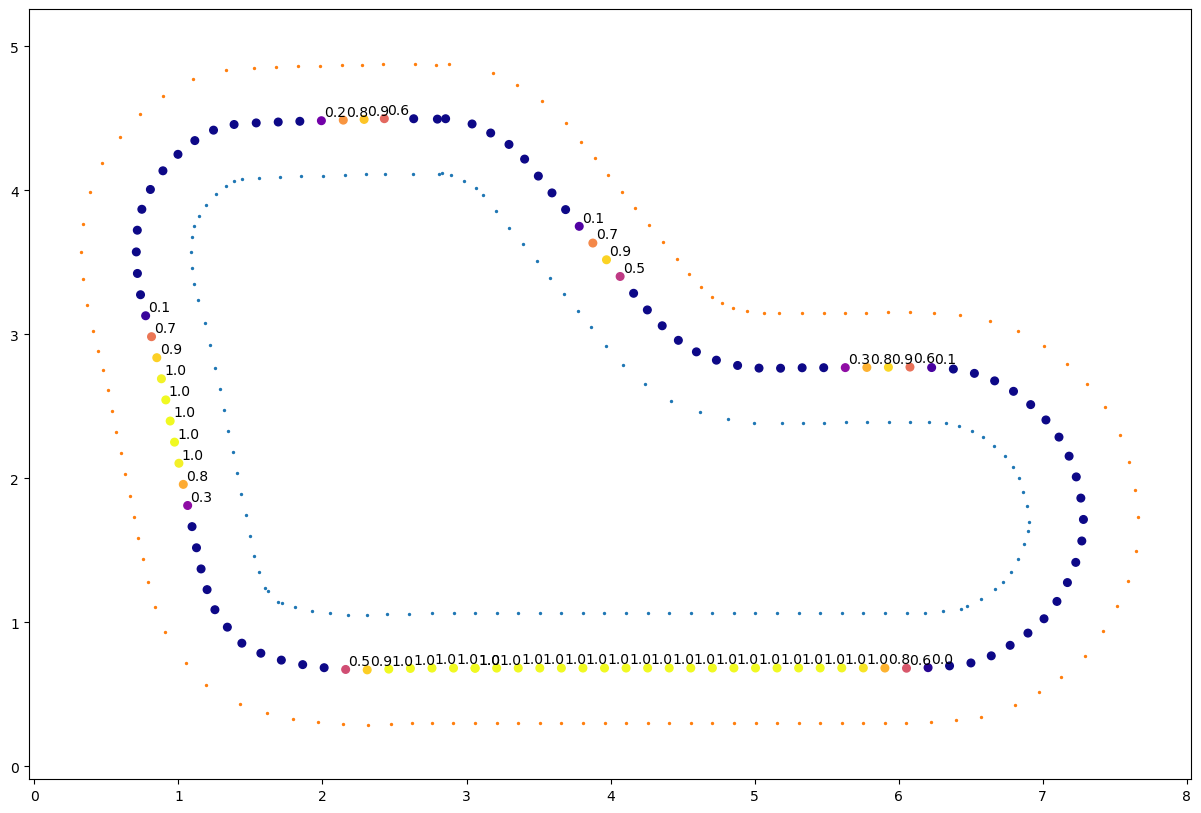

In [223]:
plot_metric(no_steering_weights)

## Output

In [224]:
side_weights

array([ 0.76923077,  0.83516484,  0.89010989,  0.93406593,  0.96703297,
        0.98901099,  1.        ,  1.        ,  0.98901099,  0.96703297,
        0.93406593,  0.89010989,  0.83516484,  0.76923077,  0.69230769,
        0.6043956 ,  0.50549451,  0.3956044 ,  0.27472527,  0.14285714,
        0.        ,  0.        ,  0.        ,  0.        , -0.05298124,
       -0.12320451, -0.21419228, -0.33168991, -0.45528813, -0.55592047,
       -0.65433926, -0.76911319, -0.88456759, -1.        , -0.87059673,
       -0.79876319, -0.70303521, -0.54998881, -0.44852226, -0.36138406,
       -0.27260266, -0.1208924 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.17052701,  0.59630162,  1.        ,
        0.70671317,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.21371   , -1.        , -0.39

In [225]:
speed_weights

array([0.98920763, 0.9937659 , 0.99670049, 0.99845225, 0.99939205,
       0.99982079, 0.9999694 , 0.99999881, 1.        , 0.99999396,
       0.9999317 , 0.99969427, 0.99909274, 0.99786818, 0.99569171,
       0.99216447, 0.98681762, 0.97911234, 0.96843984, 0.95412135,
       0.93540813, 0.91148146, 0.85833716, 0.78530032, 0.66395853,
       0.58571993, 0.49011093, 0.3955705 , 0.32328202, 0.22637519,
       0.098404  , 0.        , 0.        , 0.29909537, 0.44953908,
       0.54036869, 0.59746861, 0.64493402, 0.66971891, 0.67314546,
       0.69172392, 0.73071112, 0.81313655, 0.8543204 , 0.87404379,
       0.87015915, 0.8597005 , 0.83764771, 0.79754628, 0.73150741,
       0.6139308 , 0.42997205, 0.14789615, 0.        , 0.14858599,
       0.32746789, 0.49577578, 0.58151011, 0.6200246 , 0.62449221,
       0.62499856, 0.62495731, 0.62351505, 0.6155513 , 0.59167854,
       0.51166737, 0.3698594 , 0.09698198, 0.        , 0.19643056,
       0.44984887, 0.58715109, 0.67157938, 0.69594803, 0.70556

In [226]:
steering_weights

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.009327  , -0.03101635, -0.0687235 , -0.12711535,
       -0.20726585, -0.30513202, -0.42032417, -0.54639452, -0.68042752,
       -0.81876384, -0.91363487, -0.97410141, -1.        , -0.98162978,
       -0.92519184, -0.8330888 , -0.70503525, -0.5730547 , -0.43243765,
       -0.30867289, -0.21185095, -0.13289154, -0.06927224, -0.02128232,
        0.        ,  0.        ,  0.        ,  0.        ,  0.03002017,
        0.13499517,  0.31103864,  0.43545088,  0.43545088,  0.43545088,
        0.43545088,  0.40543072,  0.30045571,  0.12441224,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.03762225,
       -0.21366572, -0.28406745, -0.28406745, -0.28406745, -0.28

In [227]:
no_steering_weights

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.990673  , 0.95032965, 0.83193579,
       0.55541024, 0.04020334, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.11758312, 0.64343472,
       0.9181833 , 0.82624681, 0.29889034, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.45071981,
       0.91321001, 0.71108978, 0.13811211, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.61275133, 0.87824